In [217]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import preprocessing

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split
from mlxtend.evaluate import confusion_matrix

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.metrics import r2_score as R2


from sklearn.model_selection import GridSearchCV

# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

# Vars

Тут необходимые входные переменные

In [218]:
# Список имён файлов
file_names = [
    '190',
    '192',
    '193',
    '194',
    '195',
    '196',
    '197',
    '198',
    '199',
    '210',
    '211',
    '212',
    '213',
    '214',
    '215',
    '216',
    '217',
    '218',
    '220',
    '221',
    '224',
    '230',
    '231',
    '232',
    '233',
    '234',
    '235',
    '236',
    '237',
    '239',
    '451',
    '469',
    '511',
    '512',
]

# Пути до файлов .las
path_las = './data/las/'
path_las_facies = './data/las_facies/'

# Functions read files

Тут все необходимые функции

In [219]:
# Читаем файл WELL_TOPS.TXT

def get_well_tops():
    well_tops = open(f"./data/well tops.txt", "r")
    well_tops_dict = {}
    
    first_line = True

    for line in well_tops:
        if first_line:
            first_line = False
            continue

        if line.split()[0] not in well_tops_dict:
            well_tops_dict[line.split()[0]] = {}

        if line.split()[1] == 'Ach8-1_top':
            well_tops_dict[line.split()[0]]['top'] = pd.to_numeric(line.split()[-1])
        elif line.split()[1] == 'Ach8-1_bot':
            well_tops_dict[line.split()[0]]['bot'] = pd.to_numeric(line.split()[-1])
        elif line.split()[1] == 'baz':
            well_tops_dict[line.split()[0]]['baz'] = pd.to_numeric(line.split()[-1])

    return well_tops_dict

In [220]:
# Читаем .las файлы и переводим их в DataFrame
# Вариант с фильтрацией по Wall_tops

# def las_to_df(file_name, path):
    # ascii = []
    # mnem = []

    # ascii_toggle = False
    # mnem_toggle = False

    # las_file = open(f"{path}{file_name}.las", "r")


    # for line in las_file:
    #     if '~Parameter' in line: 
    #         mnem_toggle = False
    #     if mnem_toggle == True: 
    #         mnem.append(line.split()[-1])
    #     if ascii_toggle == True:
    #         line_list = line.split()

    #         if pd.to_numeric(well_tops[file_name]['top']) <= pd.to_numeric(line_list[0]) <= pd.to_numeric(well_tops[file_name]['bot']):
    #             ascii.append(pd.to_numeric(line_list))
    #     if '~Ascii' in line: 
    #         ascii_toggle = True
    #     if '~Curve' in line: 
    #         mnem_toggle = True

    # return pd.DataFrame(columns = mnem, data = ascii)

In [221]:
# Читаем .las файлы и переводим их в DataFrame
# Вариант без фильтрации по Wall_Tops

def las_to_df(file_name, path):
    ascii = []
    mnem = []

    ascii_toggle = False
    mnem_toggle = False

    las_file = open(f"{path}{file_name}.las", "r")


    for line in las_file:
        if '~Parameter' in line: 
            mnem_toggle = False
        if mnem_toggle == True: 
            mnem.append(line.split()[-1])
        if ascii_toggle == True:
            ascii.append(pd.to_numeric(line.split()))
        if '~Ascii' in line: 
            ascii_toggle = True
        if '~Curve' in line: 
            mnem_toggle = True

    return pd.DataFrame(columns = mnem, data = ascii)

In [222]:
# Собираем из двух файлов .las один DataFrame по одной скважине

def get_tabel_well(name_well):
    df = las_to_df(
        name_well, 
        path_las
    )
    df_facies = las_to_df(
        name_well, 
        path_las_facies
    )

    # Филтьтрация по Wall_Tops
    df = df[(
            well_tops[name_well]['top'] <= df.DEPTH
        ) & (
            well_tops[name_well]['bot'] >= df.DEPTH
    )]
    df_facies = df_facies[(
            well_tops[name_well]['top'] <= df_facies.DEPTH
        ) & (
            well_tops[name_well]['bot'] >= df_facies.DEPTH
    )]


    df = df.join(
        df_facies.drop(
            columns = ['DEPTH']
        )
    )
    df['WELL'] = name_well
    
    return df

In [223]:
# Собираем из всех полученных DataFrame-ов скважин один общий DataFrame

def all_in_one(name_list):
    df = pd.DataFrame([])

    for well_name in name_list:
        new_df = get_tabel_well(well_name)
        df = pd.concat([df, new_df], axis=0, ignore_index=True)

    return df

# Functions drow plots

Тут все необходимые функции

In [224]:
# Рисуем красивый график

def plot_well_logs(well_name, measures_list, df, figsize=(25,8)):
    short_mnem_list = []
    GZ_list = []

    # Выделяем GZ
    for mnem in measures_list:
        if 'GZ' not in mnem[:2]:
            short_mnem_list.append(mnem)
        else:
            if 'GZ' not in short_mnem_list:
                short_mnem_list.append('GZ')
            GZ_list.append(mnem)


    # Создаём subplot
    well_measures_df  = df.loc[df.WELL == well_name]
    fig,axes = plt.subplots(
        1, 
        len(short_mnem_list)+2, 
        figsize = figsize
    )
    axes = axes.flatten()

    # print(short_mnem_list)

    # Перебираем все колонки
    for i,col in enumerate(short_mnem_list):

        # Если это GZ, то выводим все графики GZ(1-5) в один subplot
        if col == 'GZ':
            for col_GZ in GZ_list:
                # print(col_GZ, well_measures_df[col_GZ]) 
                axes[i].plot(well_measures_df[col_GZ], well_measures_df.DEPTH)
                
            axes[i].set_title(col)
            axes[i].invert_yaxis()
        else:
            # print(col, well_measures_df[col]) #
            axes[i].plot(well_measures_df[col], well_measures_df.DEPTH)
            axes[i].set_title(col)
            axes[i].invert_yaxis()

    # Добавляем subplot с фациями
    axes[-2].imshow(well_measures_df.EF_b.values.reshape((len(well_measures_df),1)),aspect="auto",cmap="tab20")
    axes[-2].set_title("facies")

    # Добавляем subplot с фациями
    axes[-1].imshow(well_measures_df.EF_b_pred.values.reshape((len(well_measures_df),1)),aspect="auto",cmap="tab20")
    axes[-1].set_title("facies pred")

    print(f'WELL №{well_name}')
    plt.show()

# Functions Clear data

Тут все необходимые функции

In [225]:
# Отчистка главной колонки от NaN

def clear_main_col(df, col_name):
    # Переводим все NaN в col_name в -1. После чего удаляем все строки, где col_name = -1, и убираем все значения, которые меньше 0

    df[col_name] = df[col_name].fillna(-1)
    df = df[ df[col_name] != -1 ]
    df = df[df[col_name] > 0]

    df.describe()

    return( df )

In [226]:
# Очистка dataframe от NaN

def clear_df(dataframe = pd.DataFrame(), present_persent = 80, drop_col = []):
    df = dataframe
    
    # Перводим все отрицательные значения в NaN
    for col in df.columns:
        if col != 'WELL':
            df[col] = np.where(
                df[col] < 0,
                np.NaN,
                df[col]
            )

    well_coll_values_counter = {}

    for well in df.WELL.unique():
        well_df = df[df.WELL == well]

        well_coll_values_counter[well] = {}

        for col in well_df.columns:
            if well_df[col].value_counts().sum() != 0:
                well_coll_values_counter[well][col] = 1
            else: 
                well_coll_values_counter[well][col] = 0

    well_coll_values = pd.DataFrame(data = well_coll_values_counter).T

    # Определение презентабельности данных
    well_col_presnt = {}
    well_col_not_presnt = {}

    for col in well_coll_values:
        persent = round( 
            well_coll_values[col].sum() / len(well_coll_values) * 100,
            2
        ) 

        if persent > present_persent:
            well_col_presnt[col] = persent
        else:
            well_col_not_presnt[col] = persent

    # Удаление всего лишнего
    df = df.drop(columns = well_col_not_presnt.keys())
    df = df.drop(columns = drop_col)

    # Удаление лишних строк, содержащих NaN
    df = df.dropna()

    return(df)

# Functions For Models

In [227]:
def check_model( model, y_true, y_pred ):
    print(
        'Best score:', model.best_score_, 
        '\nBest params:', model.best_params_
    )

    print(
        '\n',
        confusion_matrix(
            y_true, 
            y_pred
        )
    )
    print(
        '\n', 
        classification_report(
            y_true, 
            y_pred
        )
    )

    print(
        'MSE:', 
        MSE(
            y_true, 
            y_pred
        )
    )
    print(
        'RMSE:', 
        RMSE(
            y_true, 
            y_pred
        )
    )

# Main

Основное тело программы тут

## Читаем las файлы в один dataframe

In [228]:
# Запускаем чтение well_tops
well_tops = pd.DataFrame(data = get_well_tops())

# Запускаем чтение и сбор всех данных по скважинам в один DataFrame
df = all_in_one(file_names)
df

,DEPTH,DT,AGK,BK,DS,GGKP,GK,GZ1,GZ2,GZ3,...,NGK,NKT,PS,PZ,SATURAT_new,kp_new,Soil_new,EF_b,FZ,WELL
0,3826.5,221.697006,0.494,13.09,-999.25,2.507,6.885,7.07,19.240000,30.520000,...,-999.25,3.169,278.5,17.840000,-999.25,-999.25,-999.25,4.0,-999.25,190
1,3826.6,222.334015,0.452,12.62,-999.25,2.511,7.047,7.15,19.540001,30.230000,...,-999.25,3.151,278.5,17.730000,-999.25,-999.25,-999.25,4.0,1.00,190
2,3826.7,223.231979,0.402,12.98,-999.25,2.519,7.240,6.98,19.200001,29.770000,...,-999.25,3.135,278.5,17.530001,-999.25,-999.25,-999.25,4.0,1.00,190
3,3826.8,224.129013,0.346,13.34,-999.25,2.527,7.453,6.81,18.860001,29.330000,...,-999.25,3.130,278.5,17.330000,-999.25,-999.25,-999.25,4.0,1.00,190
4,3826.9,225.231003,0.286,12.14,-999.25,2.522,7.684,6.71,18.540001,28.690001,...,-999.25,3.147,278.5,17.270000,-999.25,-999.25,-999.25,4.0,1.00,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18929,3583.6,275.903015,0.000,6.18,NaN,2.372,9.952,4.64,11.410000,15.610000,...,NaN,4.031,NaN,7.650000,-999.25,-999.25,-999.25,3.0,3.00,512
18930,3583.7,270.752014,0.000,7.42,NaN,2.430,9.803,4.81,11.360000,15.380000,...,NaN,4.204,NaN,7.720000,-999.25,-999.25,-999.25,3.0,3.00,512
18931,3583.8,268.181000,0.000,7.42,NaN,2.439,9.744,5.05,11.180000,15.180000,...,NaN,4.326,NaN,7.910000,-999.25,-999.25,-999.25,3.0,3.00,512
18932,3583.9,265.747986,0.000,7.13,NaN,2.457,9.681,5.20,10.900000,15.010000,...,NaN,4.464,NaN,8.130000,-999.25,-999.25,-999.25,3.0,3.00,512


- Без фильтра 2:44
- Фильтр 1 (Во время las to df) 6:02 (или 53.8 сек)
- Фильтр 2 (Во время get tabel well) 3:53 (или 41.1 сек)

## Выбираем главную колонку

Смотрим гистограмму значений по различным целевым колонкам и выбираем ту, в которой большая вариативность (больше разных значений)

(array([3.981e+03, 0.000e+00, 0.000e+00, ..., 8.450e+02, 5.047e+03,
        2.000e+00]),
 array([-999.25, -998.25, -997.25, ...,    3.75,    4.75,    5.75]),
 <BarContainer object of 1005 artists>)

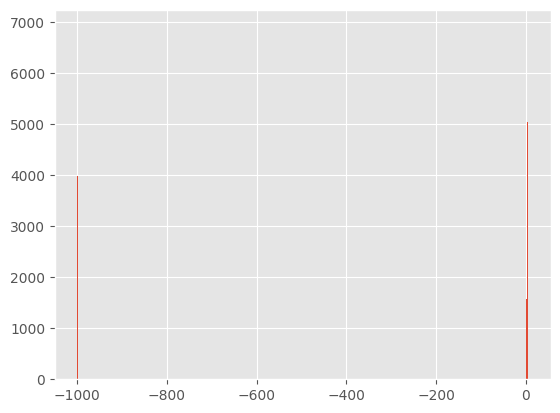

In [229]:
# Гистограмма значений EF_b до чистки
plt.hist(df.EF_b, bins = np.arange(min(df.EF_b), max(df.EF_b) + 1, 1))

Между EF_b и FZ выбрали EF_b, так как там больше разных значений

In [230]:
# Чистим целевую колонку

df = clear_main_col(df, 'EF_b')

(array([1563., 6893.,  845., 5049.]),
 array([1., 2., 3., 4., 5.]),
 <BarContainer object of 4 artists>)

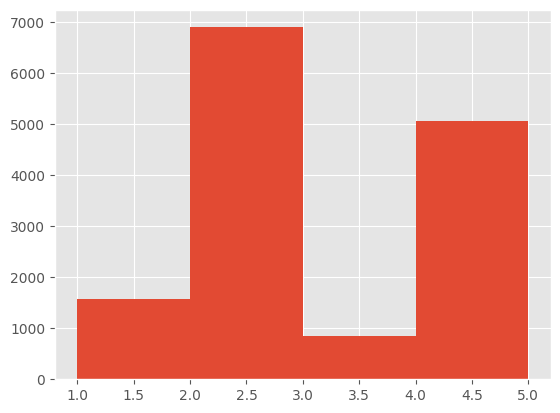

In [231]:
# Проверяем результаты чистки

plt.hist(df.EF_b, bins = np.arange(min(df.EF_b), max(df.EF_b) + 1, 1))

## Чистим dataframe от лишних колонок и строк

In [232]:
# Чистим DataFrame от колонок % пропусков в которых привышает 80% и от колонок, которые не влияют на результат

df = clear_df(
    dataframe = df, 
    present_persent = 80,
    drop_col = ['SATURAT_new', 'LIT_new', 'kp_new', 'FZ']
)

In [233]:
# Таких строк всего 2, но они влияют на обучение модели (?)

df = df[df.EF_b != 5]

## Нормализация

In [234]:
save_df = df.copy()

In [235]:
df = save_df.copy()

In [236]:
for col in df.columns:
    if col != "WELL" and col != "DEPTH" and col != "EF_b":
        df[col] = preprocessing.MinMaxScaler().fit_transform(df[col].array.reshape(-1, 1))

## Разбиваем выборку

In [237]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns = ['EF_b']), 
    df.EF_b, 
    train_size = 0.6, 
    shuffle = False,
    random_state = 42
)

In [238]:
X_train_well = X_train.WELL
X_train_depth = X_train.DEPTH
X_train = X_train.drop(columns = ['WELL'])

X_test_well = X_test.WELL
X_test_depth = X_test.DEPTH
X_test = X_test.drop(columns = ['WELL'])

In [239]:
y_train = y_train.astype(int)
y_test = y_test.astype(int)

y_test = y_test - 1
y_train = y_train - 1

## Строем модель

### Метод опорных векторов



In [240]:
params = {
    'kernel': [
        #'linear', 
        'poly', 
        # 'rbf', 
        # 'sigmoid'
    ],
    'C': [
        # 0, 
        # .1,
        .2, 
        # .3, 
        # .4, 
        # .5, 
        # .6, 
        # .7, 
        # .8, 
        # .9, 
        # 1
    ],
    'gamma': [
        # 'scale', 
        'auto'
    ],
    # 'degree': [
    #     0, 
    #     1, 
    #     2, 
    #     3, 
    #     4, 
    #     5
    # ],
    'coef0': [
    #     0, 
    #     .1, 
    #     .2, 
    #     .3, 
    #     .4, 
    #     .5, 
    #     .6, 
    #     .7, 
    #     .8, 
        .9, 
        # 1
    ],
    'shrinking': [
        # True, 
        False
    ],
    'probability': [
        True, 
        # False
    ],
    'max_iter': [
        1000, 
        # 5000,
        # 10000, 
        # 50000, 
        # 100000
    ],
    'decision_function_shape': [
        'ovo', 
        # 'ovr'
    ],
#     'break_ties': [
#         True, 
#         False
#     ]
}

In [241]:
model_SVC = GridSearchCV(
    estimator = svm.SVC(),
    param_grid = params
) 

In [242]:
model_SVC.fit(
    X_train, 
    y_train,
)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.2], 'coef0': [0.9],
                         'decision_function_shape': ['ovo'], 'gamma': ['auto'],
                         'kernel': ['poly'], 'max_iter': [1000],
                         'probability': [True], 'shrinking': [False]})

In [243]:
y_test_pred = model_SVC.predict(X_test)
y_test_pred = y_test_pred.round(0)

In [244]:
check_model(
    model_SVC,
    y_test,
    y_test_pred
)

Best score: 0.28560787009334854 
Best params: {'C': 0.2, 'coef0': 0.9, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'poly', 'max_iter': 1000, 'probability': True, 'shrinking': False}

 [[   0  180    0    0]
 [ 933 1678    0    0]
 [ 103  234    0    0]
 [  18  473   21   32]]

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.65      0.64      0.65      2611
           2       0.00      0.00      0.00       337
           3       1.00      0.06      0.11       544

    accuracy                           0.47      3672
   macro avg       0.41      0.18      0.19      3672
weighted avg       0.61      0.47      0.48      3672

MSE: 1.0441176470588236
RMSE: 1.0441176470588236


### Логическая классификация

In [245]:
params_Linear = {
    
}

In [246]:
model_Linear = GridSearchCV(
    estimator = LogisticRegression(),
    param_grid = params_Linear
)

In [247]:
model_Linear.fit(
    X_train,
    y_train
)

GridSearchCV(estimator=LogisticRegression(), param_grid={})

In [248]:
y_test_pred = model_Linear.predict(X_test)

In [249]:
check_model(
    model_Linear,
    y_test,
    y_test_pred
)

Best score: 0.7965917801173986 
Best params: {}

 [[   0  118    0   62]
 [  13 1640    0  958]
 [   0   37    0  300]
 [   0   94    0  450]]

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.87      0.63      0.73      2611
           2       0.00      0.00      0.00       337
           3       0.25      0.83      0.39       544

    accuracy                           0.57      3672
   macro avg       0.28      0.36      0.28      3672
weighted avg       0.65      0.57      0.58      3672

MSE: 1.4253812636165577
RMSE: 1.4253812636165577


### K-ближайших

In [250]:
params_KNN = {
    'n_neighbors': [
        # 5,
        # 10,
        # 15,
        20,     # Best
        # 30,
        # 40,
        # 50
    ],
    'weights': [
        'uniform',  # Best
        # 'distance' 
    ]
}

In [251]:
model_KNN = GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid = params_KNN
)

In [252]:
model_KNN.fit(
    X_train,
    y_train
)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [20], 'weights': ['uniform']})

In [253]:
y_test_pred = model_KNN.predict(X_test)

In [254]:
check_model(
    model = model_KNN,
    y_true = y_test,
    y_pred = y_test_pred
)

Best score: 0.5810012676151526 
Best params: {'n_neighbors': 20, 'weights': 'uniform'}

 [[   0    0    0  180]
 [ 171  257    0 2183]
 [   0   81    0  256]
 [   0    2    0  542]]

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       180
           1       0.76      0.10      0.17      2611
           2       0.00      0.00      0.00       337
           3       0.17      1.00      0.29       544

    accuracy                           0.22      3672
   macro avg       0.23      0.27      0.12      3672
weighted avg       0.56      0.22      0.17      3672

MSE: 2.9596949891067537
RMSE: 2.9596949891067537


### XGboost

In [255]:
params_XGB = {
    'booster': [
        'gbtree', # BEST
        # 'gblinear',
        # 'dart'
    ],
    'n_estimators': [
        # 5, 
        # 10,
        # 15,
        # 100,
        1000
    ],
    'learning_rate': [
        1,
        2
    ],
    'random_state' : [
        42
    ]
}

In [256]:
model_XGB = GridSearchCV(
    estimator = XGBClassifier(),
    param_grid = params_XGB
)

In [257]:
model_XGB.fit(
    X_train,
    y_train
)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'booster': ['gbtree'], 'learning_rate': [1, 2],
                         'n_estimators': [1000], 'random_state': [42]})

In [258]:
y_test_pred = model_XGB.predict(X_test)

In [259]:
y_test_pred 

array([1, 1, 1, ..., 3, 3, 3])

In [260]:
check_model(
    model = model_XGB,
    y_true = y_test,
    y_pred = y_test_pred
)

Best score: 0.854514539661189 
Best params: {'booster': 'gbtree', 'learning_rate': 1, 'n_estimators': 1000, 'random_state': 42}

 [[  34    0    0  146]
 [ 641  410    3 1557]
 [   8   34    0  295]
 [   0    0    0  544]]

               precision    recall  f1-score   support

           0       0.05      0.19      0.08       180
           1       0.92      0.16      0.27      2611
           2       0.00      0.00      0.00       337
           3       0.21      1.00      0.35       544

    accuracy                           0.27      3672
   macro avg       0.30      0.34      0.17      3672
weighted avg       0.69      0.27      0.25      3672

MSE: 2.3276143790849675
RMSE: 2.3276143790849675


### Стейкинг

In [270]:
base_estimators = [
    (
        'SVC', 
        model_SVC.best_estimator_
    ),
    (
        'Linear', 
        model_Linear.best_estimator_
    ),
    (
        'knn', 
        model_KNN.best_estimator_
    ),
    (
        'XGB', 
        model_XGB.best_estimator_
    ),
]

model_stack = StackingClassifier(
    estimators=base_estimators, 
    final_estimator=LogisticRegression(), 
    cv=10
)

model_stack.fit(X_train, y_train)

y_pred = model_stack.predict(X_test)

mse = MSE(y_test, y_pred)
rmse = np.sqrt(MSE(y_test, y_pred))
Rsq = R2(y_test, y_pred)

In [271]:
# df_test = pd.DataFrame(columns=['DEPTH'], data=X_test_depth)
df_test = pd.DataFrame(columns=['WELL'], data=X_test_well)

df_test = df_test.join(X_test)

# df_test['WELL'] = X_test_well
df_test['EF_b'] = y_test
df_test['EF_b_pred'] = y_test_pred

In [272]:
df_test.EF_b.unique(), df_test.EF_b_pred.unique()

(array([1, 2, 3, 0]), array([1, 0, 3, 2]))

## Выводим графики

WELL №221


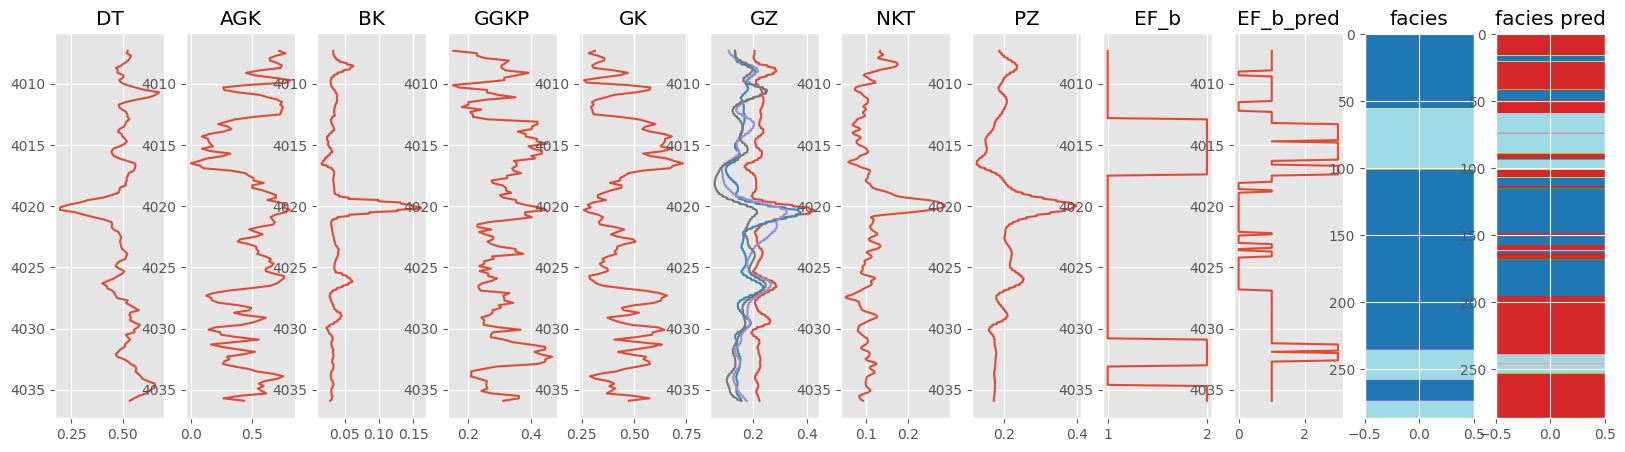

WELL №224


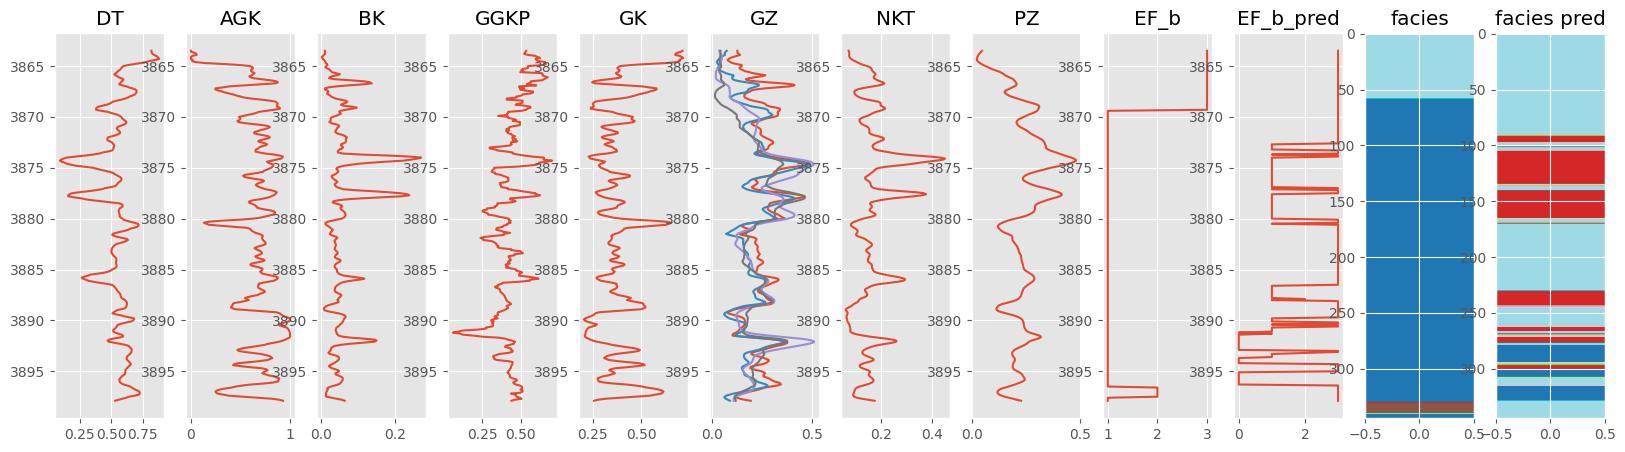

WELL №233


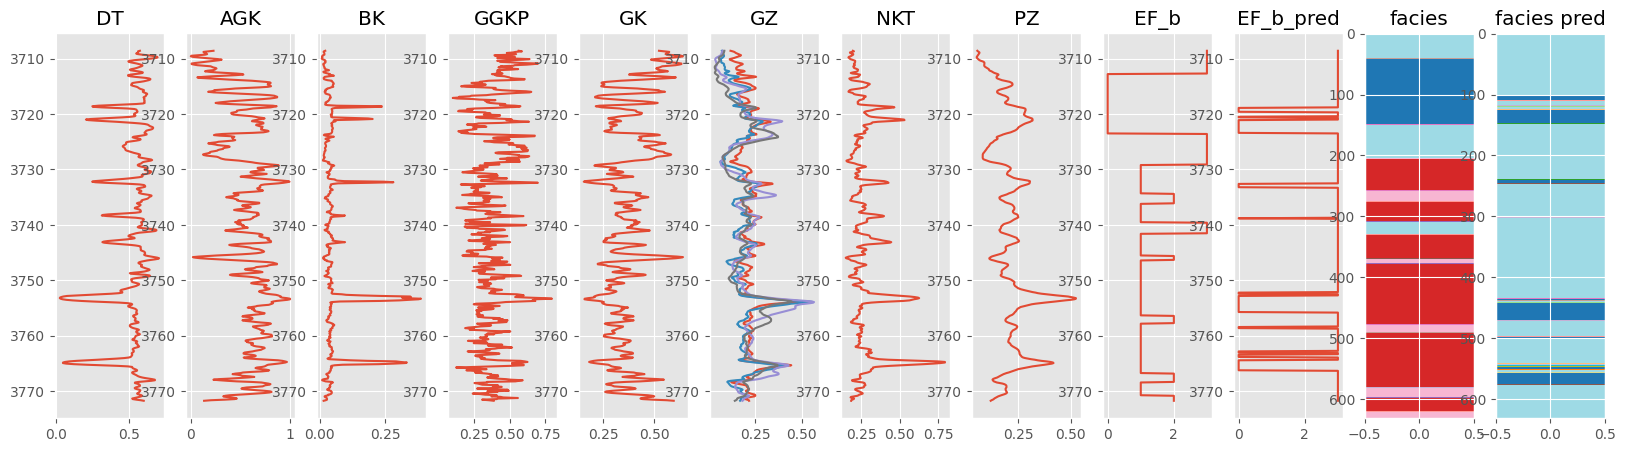

WELL №234


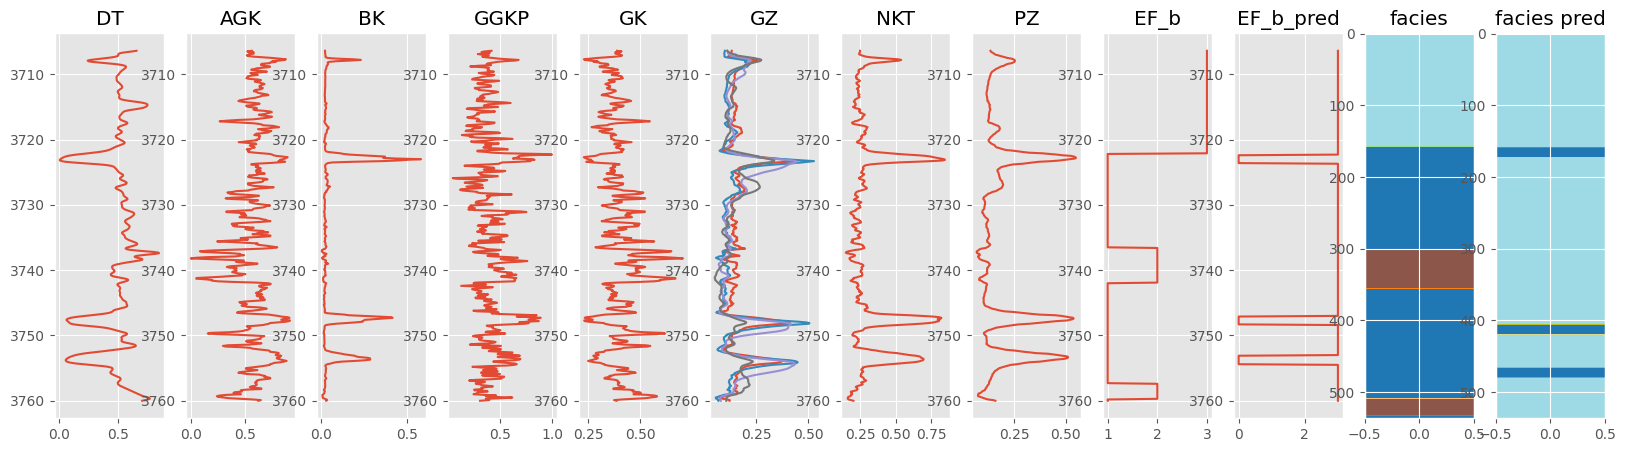

WELL №235


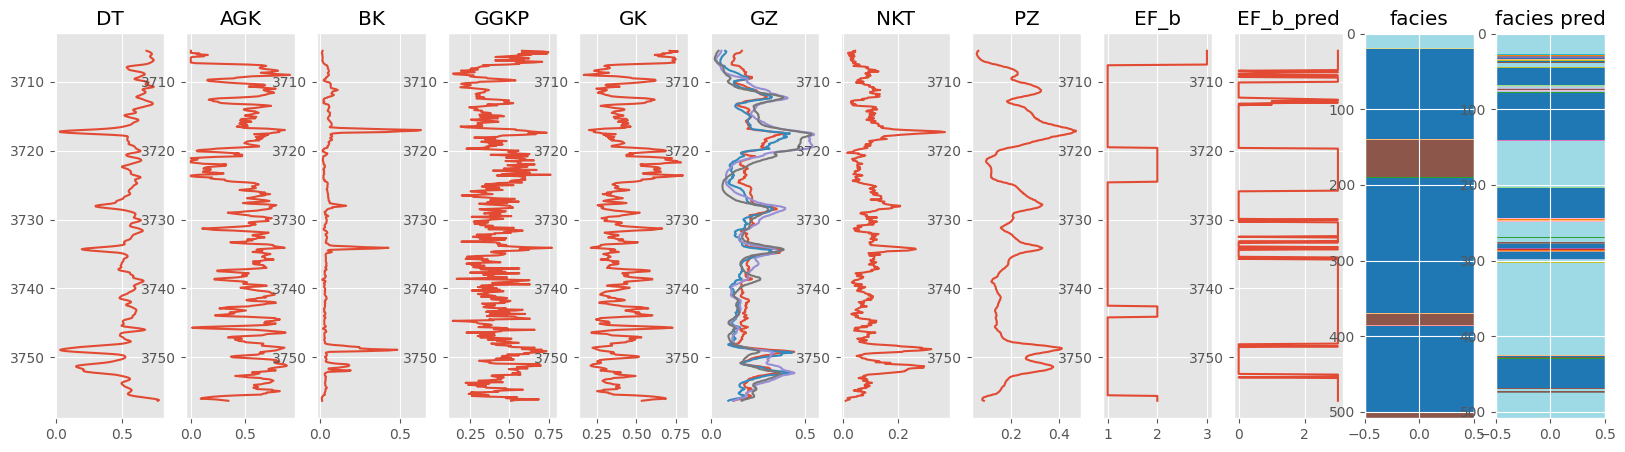

WELL №469


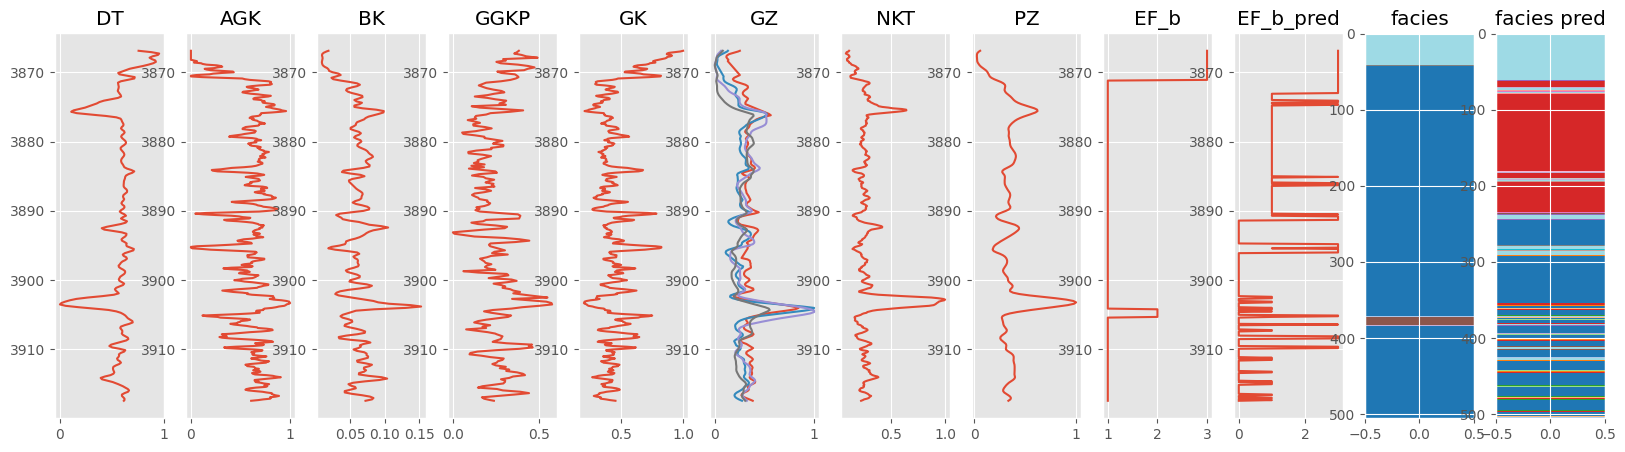

WELL №511


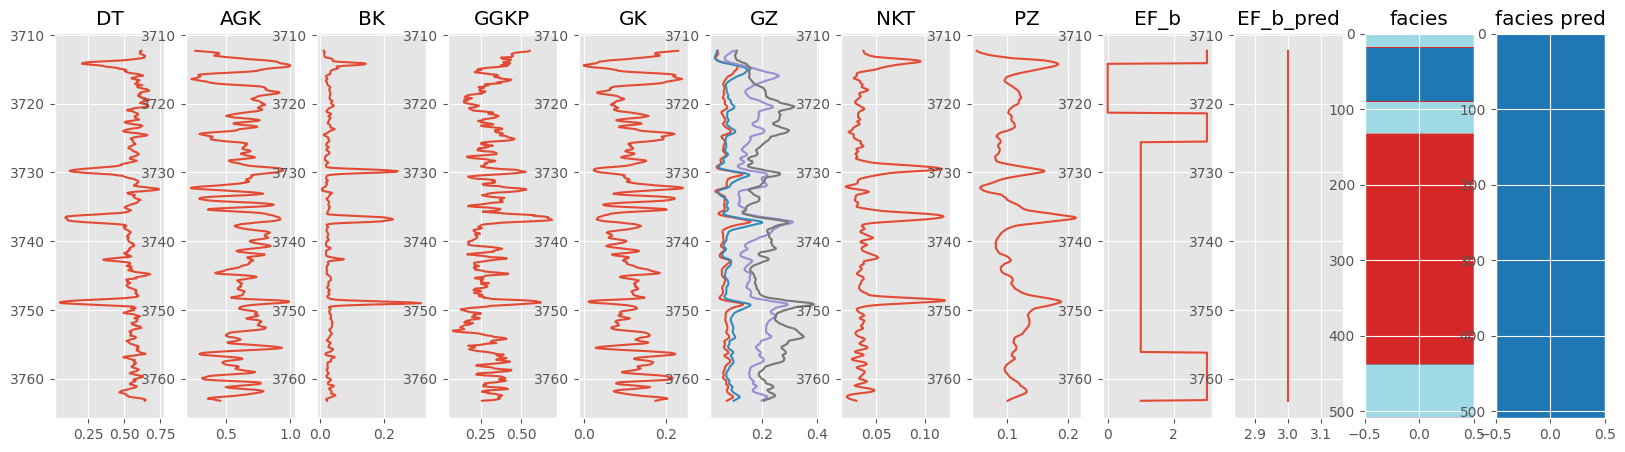

WELL №512


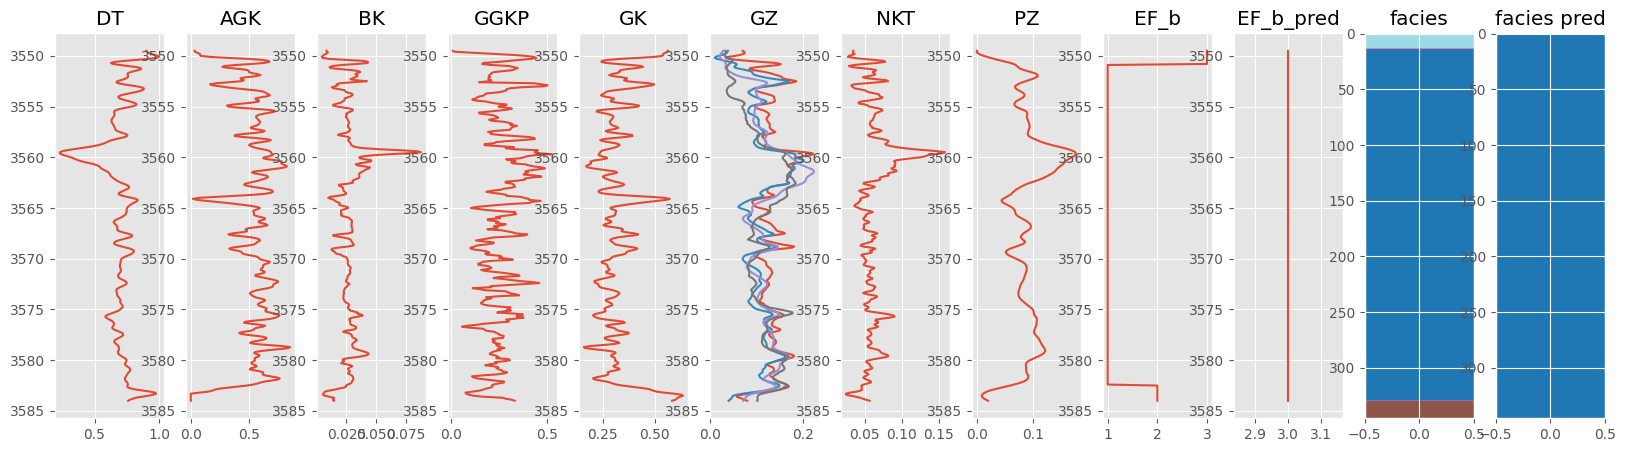

In [273]:
# Запускаем бесконечный цикл для вывода нужной нам скважины
# while True:
#     well_num = input('Введите номер скважины (0 - чтобы выйти из цикла):')

# Выводим графики по всем скважинам
for well_num in file_names:

    if well_num == '0':
        print('Конец\n')
        break
    # elif well_num not in file_names:
    #     print('Такой скважины нет\n')
    else:
        if df_test[ df_test.WELL  == well_num].count().max() > 0:
            well_name = well_num
            measures_list = df_test.drop(columns = ['DEPTH', 'WELL']).columns
            
            plot_well_logs(
                well_name,
                measures_list,
                df_test,
                figsize=(20,5)
            )
        # else:
        #     print('Данных по скважине нет\n')
        
